In [132]:
import os
import io
import cv2
import requests
import numpy as np
import json
from IPython.display import Image, display

In [133]:
full_url = "http://localhost:23006/entryimages/predict"

In [134]:
full_url_p2 = "http://localhost:23006/entryimages/countObject"

<h3>2.2) Consultas al endpoint /predict agregando como parámetro el nivel de confianza</h3>

In [ ]:
Definimos la función get_image_response que devuelve la imagen procesada con las clasificaciones encontradas, por otro lado, la sub-función response_from_server realiza la petición POST al servidor, consideramos un tipo especial de files en el request en base a la petición CURL que se realiza.

In [135]:
def response_from_server(full_url, path_image, confidence, verbose=True):  
    image_file = open(path_image, "rb")
    image_name = path_image.split("/")[-1]
    files = (
    ('confidence',(None, f"{confidence}")),
    ('file',(f"{image_name};type", image_file)))
    
    response = requests.post(full_url, files=files)
    status_code = response.status_code
    if verbose:
        msg = "¡Todo funcionó bien!" if status_code == 200 else "Hubo un error al ejecutar la solicitud."
        print(msg)
    return response

In [136]:
dir_name = "images_predicted"
if not os.path.exists(dir_name):
    os.mkdir(dir_name)

In [ ]:
La función get_image_response procesa la respuesta entrega y la convierte al formato de imagen.

In [137]:
def get_image_response(full_url, path_image, confidence, verbose=True):
    prediction = response_from_server(full_url, path_image, confidence)
    image_stream = io.BytesIO(prediction.content)
    image_stream.seek(0)
    file_bytes = np.asarray(bytearray(image_stream.read()), dtype=np.uint8)
    image = cv2.imdecode(file_bytes, cv2.IMREAD_COLOR)
    image_name = path_image.split("/")[-1]
    cv2.imwrite(f'images_predicted/{image_name}', image)
    return display(Image(f'images_predicted/{image_name}'))

<h3>2.4)  Consultas al endpoint /countObjects para realizar un contador de un objeto en particular</h3>

In [ ]:
Definimos la función response_from_server_p2 que se encarga de realizar la consulta sobre el conteo de objetos, recibiendo como parametros:

-full_url: Url del endpoint
-confidence: Confianza del modelo
-element: Elemento requerido para el conteo (string), en caso de no agregar un campo, el valor de default "all" contara todos los objetos presentes.

In [138]:
def response_from_server_p2(full_url, path_image, confidence, element, verbose=True):  
    image_file = open(path_image, "rb")
    image_name = path_image.split("/")[-1]
    files = (
    ('confidence',(None, f"{confidence}")),
    ('element',(None, f"{element}")),
    ('file',(f"{image_name};type", image_file)))
    
    response = requests.post(full_url, files=files)
    status_code = response.status_code
    if verbose:
        msg = "¡Todo funcionó bien!" if status_code == 200 else "Hubo un error al ejecutar la solicitud."
    return response

In [ ]:
La función get_image_count retorna la respuesta de response_from_server_p2, obteniendo el content necesario.

In [139]:
def get_image_count(full_url_p2, path_image, confidence, element, verbose=True):
    objects_counted = response_from_server_p2(full_url_p2, path_image, confidence, element)
    return objects_counted.content

<h3>2.2) Evaluación del endpoint /predict</h3>

In [ ]:
Podemos observar que con un confidence=0.1, el clasificador identifica 4 apple y 6 oranges, cabe destacar que identifica mal una apple como orange y por otro lado, identifica 2 objetos como orange, siendo que no lo son, identifica un lemon como orange y una subparte de un orange como un orange.

In [140]:
get_image_count(full_url_p2, "images/fruits.jpg", 0.1, "all")

b'{\n    "apple": 4,\n    "orange": 6\n}\n'

¡Todo funcionó bien!


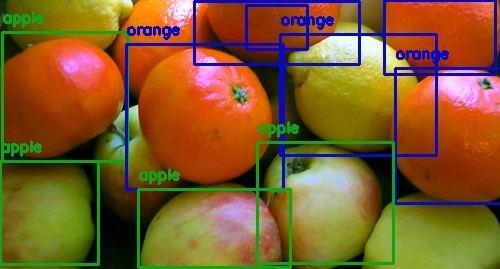

In [141]:
get_image_response(full_url, "images/fruits.jpg", 0.1)

In [ ]:
Podemos identificar para confidence=0.25 que aún sigue identificando de mala forma un apple como orange, por otro lado, identifica 4 de 5 orange de forma correcta, fallando en un lemon

In [142]:
get_image_count(full_url_p2, "images/fruits.jpg", 0.25, "all")

b'{\n    "apple": 4,\n    "orange": 5\n}\n'

¡Todo funcionó bien!


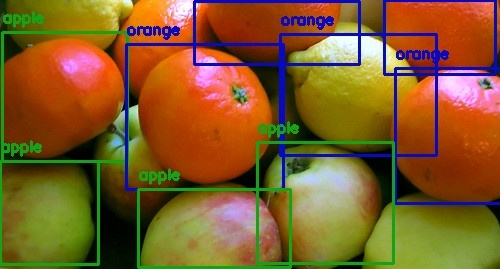

In [143]:
get_image_response(full_url, "images/fruits.jpg", 0.25)

In [ ]:
Para el caso de confidence=0.5 identifica de buena forma 2 oranges y 1 apple, en este caso deja de identificar ciertas frutas dado que el valor de confidence es demasiado alto.

In [144]:
get_image_count(full_url_p2, "images/fruits.jpg", 0.5, "all")

b'{\n    "apple": 1,\n    "orange": 2\n}\n'

¡Todo funcionó bien!


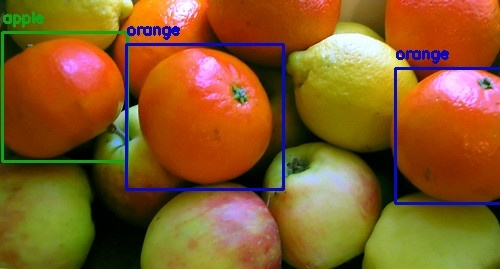

In [145]:
get_image_response(full_url, "images/fruits.jpg", 0.5)

In [ ]:
Para este caso, el valor de confidence=0.55 solamente identifica una sola fruta, un orange.

In [146]:
get_image_count(full_url_p2, "images/fruits.jpg", 0.55, "all")

b'{\n    "apple": 1\n}\n'

¡Todo funcionó bien!


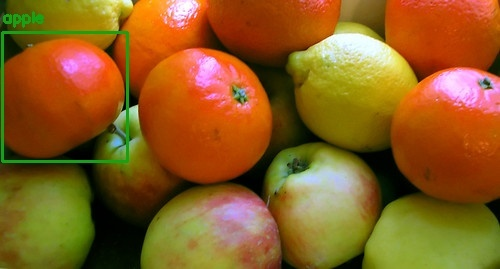

In [147]:
get_image_response(full_url, "images/fruits.jpg", 0.55)

In [ ]:
Finalmente para un valor de confidence=0.6 el clasificador no identifica frutas.

In [148]:
get_image_count(full_url_p2, "images/fruits.jpg", 0.6, "all")

b'{}\n'

¡Todo funcionó bien!


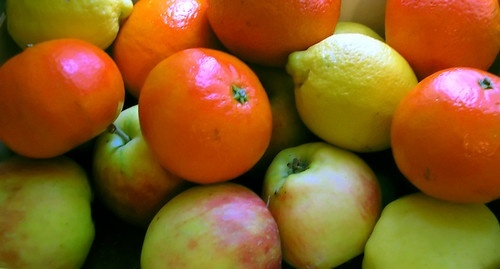

In [149]:
get_image_response(full_url, "images/fruits.jpg", 0.6)

<h3>2.4) Evaluación contador de apples</h3>

<h5>Caso 1 apple</h5>

In [150]:
get_image_count(full_url_p2, "images/apple.jpg", 0.25, "apple")

b'{\n    "apple": 1\n}\n'

<h5>Caso 2 apple</h5>

In [151]:
get_image_count(full_url_p2, "images/twoapples.jpg", 0.25, "apple")

b'{\n    "apple": 2\n}\n'

<h5>Caso 3 apple</h5>

In [152]:
get_image_count(full_url_p2, "images/apples.jpg", 0.25, "apple")

b'{\n    "apple": 2\n}\n'

¡Todo funcionó bien!


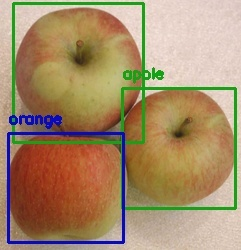

In [154]:
get_image_response(full_url, "images/apples.jpg", 0.25, "apple")

<h5>Caso 4 apple</h5>

In [155]:
get_image_count(full_url_p2, "images/fourapples.jpg", 0.25, "apple")

b'{\n    "apple": 4\n}\n'

<h5>Caso 5 apple</h5>

In [162]:
get_image_count(full_url_p2, "images/fiveapples.jpg", 0.25, "apple")

b'{\n    "apple": 5\n}\n'

¡Todo funcionó bien!


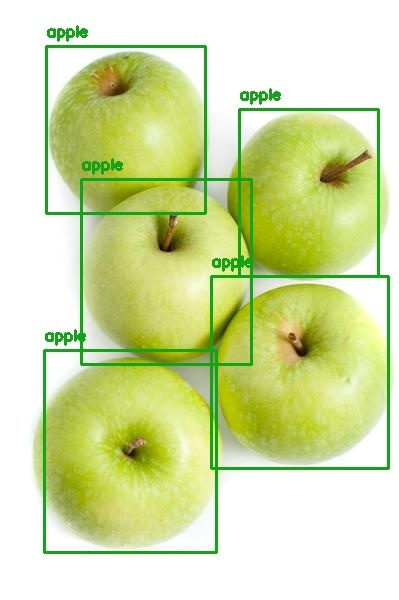

In [163]:
get_image_response(full_url, "images/fiveapples.jpg", 0.25, "apple")